In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-08 01:14:24.083860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 01:14:24.083880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Visualization helper

In [10]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    ax.legend()
    plt.show()

# Computing Accuracy and F1 values over high dimensionality

In [11]:
experiments_result = run_experiments(None, train_HD, train_Y, None, test_HD, test_Y)
experiments_result

{'RF-ACC': 0.7926470588235295,
 'RF-F1': 0.7859709313117211,
 'SVC-ACC': 0.7745098039215687,
 'SVC-F1': 0.7778885639401502,
 'KNN-ACC': 0.5627450980392157,
 'KNN-F1': 0.5748433950949942}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


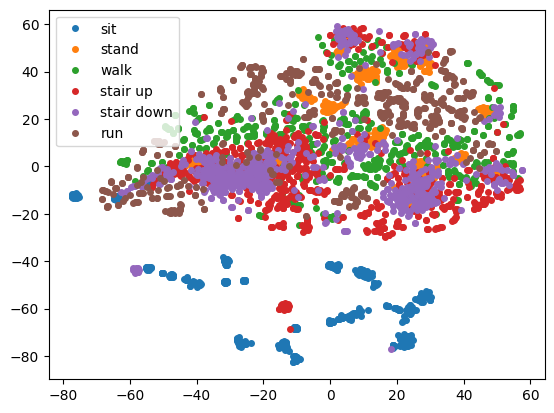

In [12]:
# Visualizing train
tsne = TSNE()
train_2D = tsne.fit_transform(train_HD)
visualize(train_2D, train_Y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


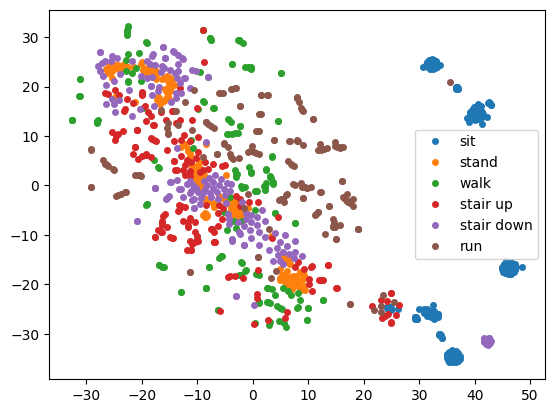

In [13]:
# Visualizing test
tsne = TSNE()
test_2D = tsne.fit_transform(test_HD)
visualize(test_2D, test_Y)

# Reducing with Generic Autoencoders

In [14]:
model_lam = 0
model_dim = 10
model_epc = 175
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=360,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 10


In [15]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

Epoch:1, P:None, Loss:22.9631, Loss-ae:22.9631, Loss-topo:5.9124
Epoch:2, P:None, Loss:23.3358, Loss-ae:23.3358, Loss-topo:10.0879
Epoch:3, P:None, Loss:22.4061, Loss-ae:22.4061, Loss-topo:8.5963
Epoch:4, P:None, Loss:22.5775, Loss-ae:22.5775, Loss-topo:9.2708
Epoch:5, P:None, Loss:23.0270, Loss-ae:23.0270, Loss-topo:10.6580
Epoch:6, P:None, Loss:22.4063, Loss-ae:22.4063, Loss-topo:11.3449
Epoch:7, P:None, Loss:22.2018, Loss-ae:22.2018, Loss-topo:12.0260
Epoch:8, P:None, Loss:22.0918, Loss-ae:22.0918, Loss-topo:16.6345
Epoch:9, P:None, Loss:22.4658, Loss-ae:22.4658, Loss-topo:12.5233
Epoch:10, P:None, Loss:22.4659, Loss-ae:22.4659, Loss-topo:15.7180
Epoch:11, P:None, Loss:23.1324, Loss-ae:23.1324, Loss-topo:20.7705
Epoch:12, P:None, Loss:22.1813, Loss-ae:22.1813, Loss-topo:19.4217
Epoch:13, P:None, Loss:22.5429, Loss-ae:22.5429, Loss-topo:23.3841
Epoch:14, P:None, Loss:22.2126, Loss-ae:22.2126, Loss-topo:18.4795
Epoch:15, P:None, Loss:21.8521, Loss-ae:21.8521, Loss-topo:22.8505
Epoch:1

KeyboardInterrupt: 

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [ ]:
model_lam = 1
model_dim = 10
model_epc = 175
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=360,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [ ]:
model_lam = 10
model_dim = 10
model_epc = 175
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=360,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [ ]:
model_lam = 100
model_dim = 10
model_epc = 175
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=360,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [ ]:
# Reducing with Convolutional Topological Autoencoders

In [ ]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [ ]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [ ]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result

# Reducing with UMAP

In [ ]:
umap_reducer = UMAP(n_components=model_dim)
umap_reducer.fit(train_HD, train_Y)

In [ ]:
train_LD = umap_reducer.transform(train_HD)
test_LD = umap_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)